In [1]:
# Importing all the necessary libraries for this project.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import re
from nltk import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import string
import math

In [2]:
### importing all the models directory

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [3]:
# VIEW ALL COLUMNS & ALL TEXT IN EACH CELL

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 20)

# Set ipython's max row display
pd.set_option('display.max_row', 200)


In [4]:
final_review = pd.read_csv('Final_Review.csv', index_col=0)
whisky_pd = pd.read_csv('Whisky_EDA.csv', index_col=0)

In [5]:
whisky_pd.drop_duplicates(inplace = True)

In [6]:
#H/T Dale Wahl/Joe Klien for helping create confusion matrix.

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

def eval_sklearn_model(y_true, predictions, average, model=None, X=None):
    """This function takes the true values for y and the predictions made by the model and prints out the confusion matrix along with Accuracy, Precision, and, if model and X provided, Roc_Auc Scores."""
    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions, average = average))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(y_true, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

In [7]:
## START WITH DROPPING STUFF THAT WONT BE USEFUL IN MODEL BUILDING

whisky_pd.drop(['Volume_ml', 'Price_Bottle$', 'WhiskyURL', 'Bottler'], axis = 1, inplace = True)

In [8]:
## Make everything lower case

columns = ['WhiskyType', 'Description', 'Distillery', 'Whisky', 'Country', 'Region', 'TasteInfo']
for i in columns:
    whisky_pd[i] = whisky_pd[i].str.lower()

In [9]:
## CREATE DUMMIES FOR WHISKYTYPE

whiskytype = pd.get_dummies(whisky_pd['WhiskyType'], prefix = 'w')
whiskytype.drop('w_rest of world whisky', axis = 1, inplace = True)


In [10]:
## CREATE DUMMIES FOR DISTILLERY TYPE

distillerytype = pd.get_dummies(whisky_pd['Distillery'], prefix = 'd')
distillerytype.drop('d_johnnie walker', axis = 1, inplace = True)

In [11]:
## CREATE DUMMIES FOR COUNTRY 

countrytype = pd.get_dummies(whisky_pd['Country'], prefix = 'c')
countrytype.drop('c_japan', axis = 1, inplace = True)

In [12]:
## CREATE DUMMIES FOR REGION

regiontype = pd.get_dummies(whisky_pd['Region'], prefix = 'r')
regiontype.drop('r_kentucky', axis = 1, inplace = True)

In [13]:
## CREATE DUMMIES FOR COLOURING. LET US TRY A DIFFERENT WAY

whisky_pd['Colouring'].replace(('Yes', 'No'), (1, 0), inplace=True)

In [14]:
## CREATE DUMMIES FOR STATUS. LET US TRY A DIFFERENT WAY

whisky_pd['Status'].replace(('Active', 'Silent'), (1, 0), inplace=True)

In [15]:
## CREATE DUMMIES FOR AGE_TYPE. LET US TRY A DIFFERENT WAY

whisky_pd['AgeType'].replace(('YAS', 'NAS'), (1, 0), inplace=True)

In [16]:
## CREATE DUMMIES FOR AGE_TYPE. LET US TRY A DIFFERENT WAY

whisky_pd['BottlingType'].replace(('Distillery', 'Independent'), (1, 0), inplace=True)

In [17]:
## CREATE DUMMIES FOR AGE_TYPE. LET US TRY A DIFFERENT WAY

whisky_pd['VintageInfo'].replace(('No Vintage', 'Vintage'), (0, 1), inplace=True)

In [18]:
## CREATE DUMMIES FOR EDITIONS

whisky_pd['LimitedEditions'].replace(('No Info', 'Limited'), (0, 1), inplace=True)

In [19]:
## CREATE DUMMIES FOR EDITIONS

whisky_pd['CaskInfo'].replace(('No Info', 'SpecialCask'), (0, 1), inplace=True)

In [20]:
## GET A LIST OF FLAVORS HERE. DROP CHARACTER ITEM


## Add Character column to Description

whisky_pd['Description'] = whisky_pd['Description'] + " " + whisky_pd['Character'].fillna('')



In [21]:
## REMOVE COLUMNS

whisky_pd.drop(['#Ratings', 'Bottling Date', 'Cask Number', 'Cask Type', 'Chill Filtered', 'Series', 
                'Location', 'Owner', 'No of Bottles', 'Year closed', 'TasteInfo', 'Character'], axis = 1, inplace = True)

In [22]:
frames = [whisky_pd, whiskytype, regiontype, countrytype, distillerytype]

whisky_pd = pd.concat(frames, axis = 1).reset_index(drop = True)

In [23]:
whisky_pd.drop(['WhiskyType', 'Country', 'Region', 'Distillery'], axis = 1, inplace = True)

In [24]:
def stemmer(description):
    print(description)
    translator = str.maketrans('', '', string.punctuation)   ### REMOVE PUNCTUATION
    descsplit = description.split(" ")
    wordstemmer = SnowballStemmer('english')
    finallist = [wordstemmer.stem(word) for word in descsplit] 
    return(' '.join(finallist))

whisky_pd['NewDescription'] = whisky_pd['Description'].apply(stemmer)

glen moray classic is the distillery's entry-level single malt, aged for an average of seven years in ex-bourbon casks, of which a high percentage are first fill - easy drinking, honeyed and excellent value.please note minor damages on presentation box. 
a no-age-statement entry-level glen grant, focusing on their mission to make light and easy-drinking whisky. this is a very accessible, approachable malt ideal for beginners or as an aperitif. Character   Vanilla     Lemon    Apple    Rhubarb
a no-age-statement expression from speyburn. bradan orach means golden salmon, according to our exhaustive research. 
loch lomond original is the entry-level bottling from this highlander. elegant yet full bodied with a hint of peat. 
loch lomond original is the entry-level bottling from this highlander. elegant yet full bodied with a hint of peat. 
the 2016 relaunch of tomatin legacy has been aged in a combination of bourbon barrels and virgin-oak casks. the rest is a whisky brimming with notes o

this eight-year-old from talisker has been released as part of douglas laing's provenence series. bottled in february 2017, this is sweet and smoky with notes of ash, malt and coal dust. 
distilled in 2006, this is a fruity and floral single malt from a lesser-known speyside gem. aged in a single port cask for 11 years, this linkwood has notes of rose, cranberry and honey. this edition has been created by independent bottlers the creative whisky company, and is part of their exclusive malts series. 
a 1999 vintage ledaig from independent bottler gordon & macphail as part of the connoisseurs choice range, bottled in 2015. ledaig is the name for peated whisky produced at tobermory on the isle of mull. 
the 1998 vintage of dalwhinnie distillers edition, bottled in 2015. each distillery's 'de' is finished in a different wood – dalwhinnie's uses oloroso-sherry casks, resulting in an added layer of rich fruit. Character   Heather    Vanilla     Honey     Oak    Grape
a rare independent bottl

the 2003 vintage of caol ila's entry in diageo's distillers edition range, taking their regular smoky malt and finishing it in sweet moscatel wine casks for an extra depth of sweetness. 
a mystery island single malt, aged in a single sherry butt for 15 years and then bottled by the creative whisky co. for their the exclusive malts series. definitely one to park on your whisky shelf. 
a 1996 vintage whisky from the jura, a small batch bourbon cask whisky further finished in a mysterious 'bourbon jn cask'. distilled on 22nd may 1996. 
an 11-year-old ledaig from signatory as part of the cask strength collection. distilled on 8 november 2005, this peated whisky was aged in a first-fill sherry butt, a combination that always proves popular. 
the second release of bruichladdich bere barley 2008 uses grain grown on islay. this has notes of honey, toast, coconut, ginger, melon and pear. 
a golden whisky that adds vanilla, coconut and tangerine notes to the classic edradour characteristics of c

a vintage distillery bottling of glenmorangie. this was distilled in 1974, aged for 20 years and was a travel retail exclusive at the time of its release.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
a very rare 1960s vintage from north port distillery, also known as brechin. this 1968 vintage was bottled by gordon & macphail for the connoisseurs choice selection in the early 1980s, around the time the distillery was closed for good. 
a 1975 vintage whisky from north port brechin distillery. this whisky has been matured for 26 years and bottled by signatory for their silent stills series. having been bottled from a single cask and cask strength, this whisky is limited to just 211 bottles. 
a 31-year-old glenlivet bottled specially for the scotch malt whisky society. distilled in 1974 and bottled at cask strength in june 2003.please note this bottle has a stained label,

a rare bottling of single malt scotch whisky from glenury distillery (as the label proclaims). this 32 year old was distilled in 1972 and bottled in october 2005 for douglas laing's old malt cask series. 
eunson's legacy was a commemorative bottling released for the distillery's 200th anniversary in 1998. bottled at 12 years of age it is named after magnus eunson, the man credited with the establishment of the distillery. 
distilled the year the cult distillery sadly closed, this 1983 port ellen was aged for 18 years before being bottled at a cask strength of 55.5% for scott's selection. 
a dumpy 1980s bottle of the delightful springbank 15yo.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
the mitchell family has called campeltown home since the 1660s, and this 1978 springbank is filled with the uisge beatha that’s kept the firm in business since 1828. 
a 1966 lochside f

a brilliantly-balanced mouth-coating beauty, this glenury royal is a very special whisky from a tragically lost distillery, and we've always been surprised that it didn't sell out years ago - especially after a 92 point review from whiskyfun. Character   Vanilla     Parma Violet    Apricot    Leather    Toffee    Wax
a special 1970 vintage glenury royal which was specially selected to be part of the rare malts series. matured for a full 29 years and bottled at cask strength. 
first bottling, with only 65 bottles made for directors, staff and shareholders. 
a bottling of 1977 vintage highland park, released at 21 years old to celebrate the bicentenary of the distillery in 1998. this was so popular, the entire release sold out pretty much straight away.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
kinclaith is now very rare, having only been made for around twenty years 

a marvellous gordon & macphail bottling of ancient strathisla, distilled in 1953 and bottled at almost 50 years of age in 2001. g&m have some very old stocks of strathisla and bottlings are highly regarded. 
a 21 year old independent bottling of ardbeg distilled shortly before they closed their onsite maltings. 
a rare 1969 vintage glenlivet, bottled in 1998 as part of the distillery's cellar collection series at the extra accurate strength of 52.76%.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
a young bottling of glen mhor that we believe was bottled in the 1960s. a rare official release from the distillery, closed since 1983 and now demolished, and aged for just 6 years.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
a rare distillery bottling of glen

a duncan taylor bottling of 1966 vintage whisky from bowmore, released as part of their peerless range. 1960s bowmore are rare for one very specific reason - they are excellent. this may distillation, matured for 36 and bottled in june 2002, promises to be continue that tradition. 
this 1939 vintage whisky was distilled at linkwood and matured for 43 years. bottled by gordon & macphail at a tame 40% during the early 80s. 
a 1964 vintage glenlivet from their highly acclaimed cellar collection series of bottlings. this bottle is one of sukhinder's all-time favourite glenlivets, much praise indeed. 
a rare 1963 vintage bowmore bottled under their vintage label in, we estimate, the 1980s.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
an old bottle of bowmore 1966 vintage whisky. this was aged for 37 years before bottling in june 2003. 
a rare example of pre-war whisky, this

a wonderful old bottle of deluxe 12yo blended scotch, bottled at 43% for ny importers bellows & co around the 1930s. please note this bottle has a bottom shoulder fill level.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
a great looking and well kept bottle of black & white from the 1940s, complete with royal crest and 'by appointment to hm the king'.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
a dark glass bottle of something special blended whisky that we think was released sometime in the 1940s.please note that this is an old bottle and the closure may have deteriorated; care should be taken when opening the bottle. as such, the item is sold as described. 
an old bottling of findlater's v.o. blended scotch whisky, released at 10 years of age in, we 

this irish single malt was distilled at an undisclosed distillery. produced in 2000 it was aged for more than 15 years in a single sherry hogshead. 
volume iii in teeling's the revival series is a 14-year-old whiskey. matured initially in ex-bourbon barrels before being finished for the final year in pineau-des-charentes casks, this has notes of dried fruit, toffee, almonds and chocolate. 
a higher intensity bottling from the walsh distillery as part of their premium writers' tears range. only 5280 bottles have been produced for 2017, offering notes of vanilla, honey, ginger, butterscotch and apple. the perfect gift for anyone with a novel languishing in a drawer. 
terrific whiskey from midleton, part of the very rare series that was first created by then master distiller barry crockett in 1984. this 2017 edition includes the oldest whiskeys used in the blend so far – 26-year-old single pot still whiskey and 32-year-old grain whiskey – and in total the blend ranges from 12 years to 32 

aged in japan from scottish malt and canadian grain, togouchi 18 year old is aged in an abandoned railway tunnel in the eponymous town – a malty, earthy and spicy whisky. 
the follow-up to rindo in mars's nature of shinshu series, this is a blend of peated whisky, some of which has been aged in japanese-wine barrels. the label represents the cherry blossom that is prevalent around the distillery. 
a younger expression of hakushu, this well-mannered 10yo represents one of the gentlest introductions to the elegant, impeccably-constructed qualities of japanese malt whisky. 
the first bottling in mars's new nature of shinshu range – each entry is named after the flora local to the eponymous distillery. rindo means 'gentian' and has a distinctly aromatic character thanks to ageing exclusively in a combination of ex-bourbon, sherry and japanese wine casks. 
the 2015 release of chichibu on the way, a series charting the fledgling distillery's progress. this is a multi-vintage vatting of whisk

CHANGING STOP WORDS LIST HERE. TO INCORPORATE A LOT OF WORDS THAT DO NOT ADD ANY INFORMATION

In [25]:
## Defining stop words here before we process 'Description'

from nltk.corpus import stopwords
new_stop = stopwords.words('english')

## Adding Column Names to stop words because no need for them in the description

columnnames = list(whisky_pd.columns)
columnnames = [x.lower().split() for x in columnnames]


import itertools
columnnames = list(itertools.chain.from_iterable(columnnames))

new_stop.extend(columnnames)

## now stop words contain words from distillery, country, region, numbers (age), years(vintage)

units = ['zero', 'one','two','three','four','five','six','seven','eight','nine']
teens = ['eleven','twelve','thirteen','fourteen','fifteen','sixteen', \
             'seventeen','eighteen','nineteen']
tens = ['ten','twenty','thirty','forty','fifty','sixty','seventy', \
            'eighty','ninety']

#syears =  [str(x) for x in range(0,101)]
#strvintage =  [str(x) for x in range(1900, 2018)]
# svintage =  [str(x) + 's' for x in range(1900, 2018)]
# stryears =  [str(x) + 'year' for x in range(0,101)]
# syoyears = [str(x) + 'yo' for x in range(0,101)]

otherwords = ['year', 'old', 'bottle', 'bottle', 'whisky', 'whiskey', "'s", 'bottled', 'distillery', 'character', 'characters', 'please', 'note', 'years']

new_stop = new_stop + otherwords

In [26]:
## Remove all the d_, r_, c_, w_ types so that we don't get repeats.

new_stop = [s.replace("d_", '') for s in new_stop]
new_stop = [s.replace("r_", '') for s in new_stop]
new_stop = [s.replace("c_", '') for s in new_stop]
new_stop = [s.replace("w_", '') for s in new_stop]
new_stop = sorted(list(set(new_stop)))

In [27]:
## START WITH COUNTVECTORIZER

countvec = CountVectorizer(stop_words=new_stop, max_features=2000, ngram_range=(1,1))
wordfeatures = countvec.fit_transform(whisky_pd["NewDescription"])

descriptions = pd.DataFrame(wordfeatures.todense(),columns=countvec.get_feature_names())

In [28]:
## GET LIST OF COUNTVECTORIZED COLUMNS

cols = descriptions.columns

In [29]:
## LIST OF MOST FREQUENTLY USED WORDS

top_50 = descriptions.transpose().sum(axis = 1).sort_values(0, ascending = False)
top_50 = top_50.reset_index()
top_50.columns = ['Word', "Frequency"]

In [30]:
## ARRANGE THEM IN ALPHABETICAL ORDER FOR EASY VIEWING

descriptions = descriptions.reindex_axis(sorted(descriptions.columns), axis=1)

In [31]:
## GET FLAVOR LIST & RENAME COLUMNS THAT ARE FLAVORS TO F_FLAVOR 

newflavors = ['f_' + x for x in cols if x in completeflavors]
oldflavors = [x for x in cols if x in completeflavors]

## GETTING RENAMING DONE HERE

columndict = dict(zip(oldflavors, newflavors))
descriptions = descriptions.rename(columns = columndict)

### STARTING WITH BINARY CLASS MODEL FIRST & THEN MOVING TO THE MULTICLASS MODEL LATER

In [32]:
### START WITH MODEL BUILDING HERE GUYS!! FIX WHISKY LATER!! FIX THE MISSING AGES LATER TOO!!

Xbin = whisky_pd.drop(['Description', 'Whisky', 'WhiskyAge', 'WhiskyVintage', 'Price_L', 'Class', 'NewDescription'], axis = 1)
Xbin = pd.concat([Xbin, descriptions], axis = 1).drop('BinClass', axis = 1)

ybin = whisky_pd['BinClass']

In [33]:
Xbin_train, Xbin_test, ybin_train, ybin_test = train_test_split(Xbin, ybin, random_state = 42, test_size = 0.3)

print(Xbin_train.shape, Xbin_test.shape)
print(ybin_train.shape, ybin_test.shape)

(1926, 2547) (826, 2547)
(1926,) (826,)


In [35]:
%%time
logit = LogisticRegression()

param_grid = {'penalty' : ['l1', 'l2'],
                'C' : [10 ** i for i in range(-2, 5)]}

grid = GridSearchCV(logit, param_grid, cv=3)

grid.fit(Xbin_train, ybin_train)

best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_logit = grid.best_estimator_

model = best_logit.fit(Xbin_train, ybin_train)
logit_predictions = best_logit.predict(Xbin_test)

score = best_logit.score(Xbin_test, ybin_test)

print("{} Score: {:0.3}".format('Logitistic Classifier', score, '\n'))

print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)

eval_sklearn_model(ybin_test, logit_predictions,'binary')

Logitistic Classifier Score: 0.895
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Best Hyperparameters we tested for 
 {'params': [('C', 1), ('penalty', 'l2')], 'score': 0.89408099688473519}
True Negative:  472 | False Positive:  40
False Negative:  47 | True Positive:  267 

Sensitivity (TP/ TP + FN):  0.850318471338
Specificity (TN/ TN + FP):  0.921875 

Accuracy:  0.894673123487
Precision:  0.869706840391


CPU times: user 3.73 s, sys: 1.16 s, total: 4.89 s
Wall time: 5.04 s


In [57]:
modelpdbin = pd.DataFrame(model.coef_)
modelpdbin.columns = Xbin_train.columns

modelpdbin = modelpdbin.transpose()
modelpdbin.columns = ['Coefficients']

modelpdbin = modelpdbin.sort_values('Coefficients', ascending=False).reset_index()

modelpdbin = modelpdbin[~modelpdbin['index'].str.contains('_')]
modelpdbin

,index,Coefficients
2,oldest,1.303506
3,incred,1.301575
5,walker,1.280465
6,VintageInfo,1.268219
7,1966,1.200190
8,except,1.134923
9,legendari,1.133646
10,1969,1.069757
11,vintag,1.051488
13,50,1.017417


In [ ]:
%%time

rfbin = RandomForestClassifier(random_state=42, n_jobs=-1)

rfbin.fit(Xbin_train, ybin_train)


param_grid = {'n_estimators' : [100, 200, 500, 1000],
             'max_features' : [10, 50, 100, 500, 1000],
             'min_samples_leaf' : [1,5,10,50,100,200,500]}

grid = GridSearchCV(rfbin, param_grid, cv=3)

grid.fit(Xbin_train, ybin_train)


best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_rf = grid.best_estimator_

best_rf.fit(Xbin_train, ybin_train)

rf_predictions = best_rf.predict(Xbin_test)

score = best_rf.score(Xbin_test, ybin_test)

print("{} Score: {:0.3}".format('Random Forest Classifier', score, '\n'))

print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)


In [ ]:
### BINARY CLAS IMPORTANCES USING RANDOMFOREST

importancesbin = pd.concat([pd.DataFrame(Xbin_train.columns),pd.DataFrame(rfbin.feature_importances_)], axis = 1)
importancesbin.columns = ['Feature', 'Importance']
importancesbin = importancesbin.sort_values('Importance', ascending=False)

### MOVING TO THE MULTICLASS MODEL HERE

In [38]:
### START WITH MODEL BUILDING HERE GUYS!! FIX WHISKY LATER!! FIX THE MISSING AGES LATER TOO!!

X = whisky_pd.drop(['Description', 'Whisky', 'WhiskyAge', 'WhiskyVintage', 'Price_L', 'BinClass', 'NewDescription'], axis = 1)
X = pd.concat([X, descriptions], axis = 1).drop('Class', axis = 1)

y = whisky_pd['Class'] # THIS HAS 0-1-2-3 as the classes of whisky

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1926, 2547) (826, 2547)
(1926,) (826,)


In [40]:
%%time
logitmulti = LogisticRegression(random_state=42)

param_grid = {'penalty' : ['l1', 'l2'],
                'C' : [10 ** i for i in range(-2, 5)],
             'class_weight' : [None, 'balanced']}

grid = GridSearchCV(logitmulti, param_grid, cv=3)

grid.fit(X_train, y_train)


best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_logit = grid.best_estimator_

multimodel = best_logit.fit(X_train, y_train)
logit_predictions_multi = best_logit.predict(X_test)

score = best_logit.score(X_test, y_test)

print("{} Score: {:0.3}".format('Logitistic Classifier', score, '\n'))

print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)

eval_sklearn_model(y_test, logit_predictions_multi, 'micro')

Logitistic Classifier Score: 0.668
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 

Best Hyperparameters we tested for 
 {'params': [('C', 0.1), ('class_weight', 'balanced'), ('penalty', 'l2')], 'score': 0.65212876427829702}
True Negative:  68 | False Positive:  30
False Negative:  36 | True Positive:  120 

Sensitivity (TP/ TP + FN):  0.769230769231
Specificity (TN/ TN + FP):  0.69387755102 

Accuracy:  0.668280871671
Precision:  0.668280871671


CPU times: user 18.1 s, sys: 2.07 s, total: 20.2 s
Wall time: 19.4 s


In [41]:
modelpd = pd.DataFrame(multimodel.coef_)
modelpd.columns = X_train.columns

modelpd.head()

modelpd = modelpd.transpose()
modelpd.columns = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

modelpd = modelpd.sort_values('Class 0', ascending=False).reset_index()
modelpd



,index,Class 0,Class 1,Class 2,Class 3
0,Status,0.721191,0.354261,-0.253152,-0.508548
1,light,0.712754,-0.121438,-0.444094,-0.032557
2,12,0.599230,-0.187737,-0.098008,-0.282573
3,eight,0.514087,0.342629,-0.431170,-0.109264
4,blend,0.467848,-0.398831,-0.109928,-0.205378
5,BottlingType,0.443845,-0.178488,-0.504531,0.272619
6,start,0.418736,-0.219556,-0.189854,0.028808
7,d_glen moray,0.364593,-0.025130,-0.089495,-0.212591
8,origin,0.340543,-0.165968,0.016790,-0.243139
9,la,0.330912,0.064759,-0.202377,-0.006916


In [ ]:
%%time

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)


param_grid = {'n_estimators' : [100, 200, 500, 1000],
             'max_features' : [10, 50, 100, 500, 1000],
             'min_samples_leaf' : [1,5,10,50,100,200,500]}

grid = GridSearchCV(rf, param_grid, cv=3)

grid.fit(X_train, y_train)


best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_rf = grid.best_estimator_

best_rf.fit(X_train, y_train)

rf_predictions = best_rf.predict(X_test)

score = best_rf.score(X_test, y_test)

print("{} Score: {:0.3}".format('Random Forest Classifier', score, '\n'))

print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)

In [ ]:
## GET FEATURE IMPORTANCES

importances = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)], axis = 1)
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=False)

## VISUALIZATIONS

In [42]:
import matplotlib.style as style
style.use('seaborn-poster')
style.use('fivethirtyeight')


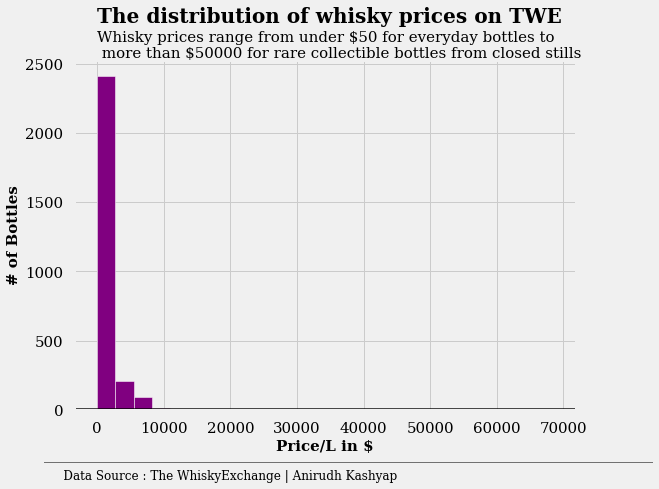

In [58]:
#PLOTTING THE OVERALL DISTRIBUTION


plt.figure(figsize=(8,6))
plt.rcParams["font.family"] = "serif"
dist_plot = plt.hist(whisky_pd['Price_L'], bins = 25, linewidth=0.5, edgecolor = 'white', color = 'purple')
plt.xticks(fontsize = 15) #FONT OF TICKS
plt.yticks(fontsize = 15)
plt.xlabel('Price/L in \$', fontsize = 15, weight = 'bold') ### XLABEL
plt.ylabel('# of Bottles', fontsize = 15, weight = 'bold')  ### YLABEL
plt.text(x=0, y=2800, s = 'The distribution of whisky prices on TWE', fontsize = 20, weight = 'bold') ## TOP HEADER
plt.text(x=0, y=2550, s = 'Whisky prices range from under \$50 for everyday bottles to\n more than \$50000 for rare collectible bottles from closed stills', fontsize = 15)
plt.axhline(y = 2, color = 'black', linewidth = 3, alpha = .7)
plt.text(x=-8000, y=-500, s = '     Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = -8000, y = -350,
    s = '_______________________________________________________________________________________',
    color = 'black', alpha = .7)

plt.show()


In [44]:
discusclass =list(whisky_pd['Class'].value_counts().keys())
discusvalues = list(whisky_pd['Class'].value_counts().values)

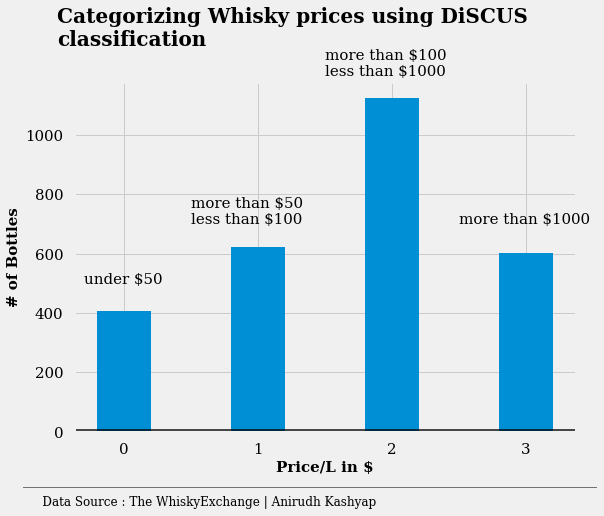

In [45]:
#PLOTTING THE CLASSIFICATION DISTRIBUTION

plt.figure(figsize=(8,6))
boxplot = plt.bar(discusclass, discusvalues, width = 0.4, align = 'center')
plt.xlabel('Price/L in \$', fontsize = 15, weight = 'bold')
plt.ylabel('# of Bottles', fontsize = 15, weight = 'bold')
plt.xticks(discusclass)
plt.axhline(y = 5, color = 'black', linewidth = 3, alpha = .7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(x=-0.5, y=1300, s = 'Categorizing Whisky prices using DiSCUS\nclassification', fontsize = 20, weight = 'bold')
plt.text(x=-0.3, y=500, s = 'under $50', fontsize = 15)
plt.text(x=0.5, y=700, s = 'more than $50\nless than $100', fontsize = 15)
plt.text(x=1.50, y=1200, s = 'more than $100\nless than $1000', fontsize = 15)
plt.text(x=2.50, y=700, s = 'more than $1000', fontsize = 15)
plt.text(x=-0.75, y=-250, s = '     Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = -0.75, y = -175,
    s = '__________________________________________________________________________________',
    color = 'black', alpha = .7)
plt.show()

In [46]:
binclass =list(whisky_pd['BinClass'].value_counts().keys())
binvalues = list(whisky_pd['BinClass'].value_counts().values)

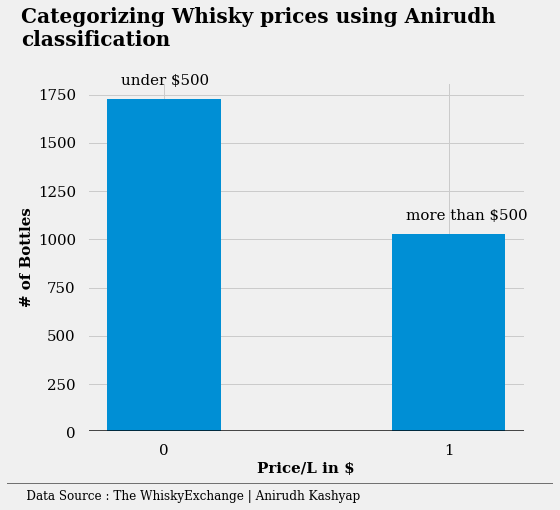

In [47]:
#PLOTTING THE BINARY CLASS DISTRIBUTION

plt.figure(figsize=(7,6))
boxplot = plt.bar(binclass, binvalues, width = 0.4, align = 'center')
plt.xlabel('Price/L in \$', fontsize = 15, weight = 'bold')
plt.ylabel('# of Bottles', fontsize = 15, weight = 'bold')
plt.xticks(binclass, size='small')
plt.axhline(y = 5, color = 'black', linewidth = 3, alpha = .7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(x=-0.5, y=2000, s = 'Categorizing Whisky prices using Anirudh\nclassification', fontsize = 20, weight = 'bold')
plt.text(x=-0.15, y=1800, s = 'under $500', fontsize = 15)
plt.text(x=0.85, y=1100, s = 'more than $500', fontsize = 15)
plt.text(x=-0.55, y=-350, s = '     Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = -0.55, y = -250,
    s = '______________________________________________________________________________',
    color = 'black', alpha = .7)
plt.show()

In [48]:
modelodds = modelpd[['Class 0', 'Class 1', 'Class 2', 'Class 3']].apply(lambda x: np.e**x)
modelodds['Factor'] = modelpd['index']
modelodds = modelodds[['Factor', 'Class 0', 'Class 1', 'Class 2', 'Class 3']]

In [49]:
## THIS CELL BLOCK IS VERY VERSATILE CHANGE USING NOTES BELOW TO SORT INFO

modelodds = modelodds.sort_values('Class 3', ascending=False).reset_index(drop = True)

modelodds = modelodds[~modelodds['Factor'].str.contains('_')]

modelodds.head(15)
bars = tuple(modelodds['Factor'].head(15))

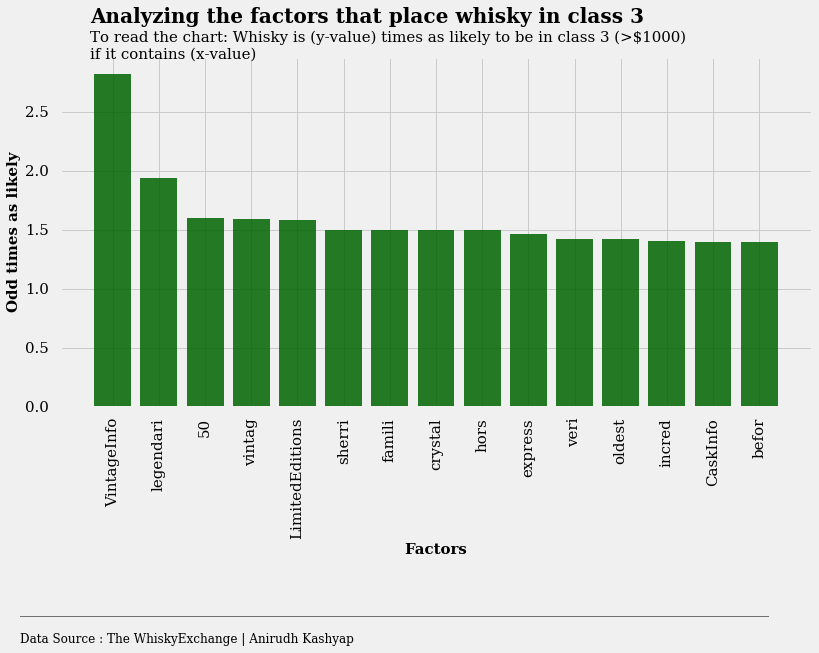

In [52]:
#PLOTTING THE CLASSIFICATION ODDS DISTRIBUTION CLASS 3

plt.figure(figsize=(12,6))

bars = tuple(modelodds['Factor'].head(15))
y_pos = np.arange(len(bars))
odds_number = list(modelodds['Class 3'].head(15))


barplot = plt.bar(y_pos, odds_number, color = 'darkgreen', alpha = 0.85)
plt.xlabel('Factors', fontsize = 15, weight = 'bold')
plt.ylabel('Odd times as likely', fontsize = 15, weight = 'bold')
plt.xticks(y_pos, bars, rotation=90)
# plt.axhline(y = 0, color = 'black', linewidth = 3, alpha = .7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(x=-0.5, y=3.25, s = 'Analyzing the factors that place whisky in class 3', fontsize = 20, weight = 'bold')
plt.text(x=-0.5, y=2.95, s = 'To read the chart: Whisky is (y-value) times as likely to be in class 3 (>$1000)\nif it contains (x-value)', fontsize = 15)
plt.text(x=-2, y=-2.0, s = 'Data Source : The WhiskyExchange | Anirudh Kashyap', fontsize = 12, color = 'black') 
plt.text(x = -2, y = -1.75, s = '___________________________________________________________________________________________________________'
         ,color = 'black', alpha = .7)
plt.show()

In [56]:
## THIS CELL BLOCK IS VERY VERSATILE CHANGE USING NOTES BELOW TO SORT INFO

modelodds = modelodds.sort_values('Class 1', ascending=False).reset_index(drop = True)

modelodds = modelodds[~modelodds['Factor'].str.contains('_')]

modelodds.head(15)
bars = tuple(modelodds['Factor'].head(15))

bars

('strength',
 'bell',
 '15',
 'also',
 'fine',
 '10',
 'barley',
 'first',
 'pair',
 'casks',
 'Status',
 'round',
 '2017',
 'part',
 'finish')